In [2]:
import math
import pandas as pd
import numpy as np
import itertools, functools
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter

from skimage.io import imread
from skimage.data import shepp_logan_phantom
from skimage.transform import iradon, iradon_sart, radon, rescale

import pickle
import os
import multiprocessing as mp
import glob

import time

## Defining constants

In [3]:
DOSES=["020","080","280"]

In [4]:
#SLICES=5 #How many slices/periods to load

In [5]:
ANGLES=720*2*2 #Number of views to use for a sinogram
HALF_ANGLES=ANGLES//2
PROJECTIONS=896
HALF_PROJECTIONS=PROJECTIONS//2
START_PERIOD=7 #From where to take the views for the sinogram. If x, then view number x*ANGLES is the first view to use.
SMALL_R=518
BIG_R=910
FULL_CIRCLE=2*math.pi
SEMI_CIRCLE=FULL_CIRCLE/2
PERPENDICULAR_ANGLE=math.pi/2
THICKNESS=16

In [6]:
MAX_DISPLACEMENT=math.sqrt(SMALL_R**2-(BIG_R/2)**2)
HALF_VIEW_ANGLE=math.asin(MAX_DISPLACEMENT/SMALL_R)
VIEW_ANGLE=2*HALF_VIEW_ANGLE

## Multi-threaded reading of view measurements from csv

In [16]:
count_errors = itertools.count() #I am not perfectly sure if this is atomic.
#Atomic stuff seems to be a surprising downside of Python
# - at least I couldn't find trivial packages for this purpose.

def set_strip(do_exp, csv_path):
    try:
        arr=np.genfromtxt(csv_path,delimiter=',')
        if do_exp:
            arr=np.exp(arr)
            arr=np.clip(arr,0,255)
            arr=np.uint8(arr)
        else:
            arr=(arr-np.min(arr))/(np.max(arr)-np.min(arr))*255
        return arr
    except: #Some csv-s are empty, DON'T KNOW WHY
        value = next(count_errors)
        print(f"ERROR number {value} in file {csv_path}")
        return None

def get_strips(dose, do_exp=False, max_cnt=None, fill_nones=True, parallel_jobs=mp.cpu_count()):
    views_location=f"/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose{dose}/out"
    cnt=0
    csv_paths=sorted(glob.glob(f"{views_location}/*.csv"),key=lambda x:int(x[59:-4]))
    if not max_cnt:
        max_cnt=len(csv_paths)

    start = time.time()
    print(f"Reading of {dose} mAs dose input started")
    print(f"It will take approximately {3.0*max_cnt/48000} minutes on Hulk5 or {5.0*max_cnt/48000} on Gpu2.")

    with mp.Pool(parallel_jobs) as pool:
        strips = pool.map(functools.partial(set_strip,do_exp), csv_paths[:max_cnt])
        if fill_nones:
            strips_list=[]
            last=None
            for x in strips:
                if x is not None:
                    strips_list.append(x)
                    last=x
                elif last is not None:
                    strips_list.append(last)
                else:
                    raise ValueError("The first is already empty")            
            strips=np.array(strips_list)
        else:
            strips=np.array([x for x in list(strips) if x is not None])
        
    end = time.time()
    print(f"Reading of {dose} mAs dose input has finished")
    print(f"{len(strips)} views were read")
    print(f"It took {(end - start)/60} minutes")
    
    return strips

In [17]:
used_doses=DOSES # OR ["280"]
strips=dict()
for dose in used_doses:
    strips[dose]=get_strips(dose)#, max_cnt=ANGLES*SLICES)

Reading of 020 mAs dose input started
It will take approximately 3.0245 minutes on Hulk5 or 5.0408333333333335 on Gpu2.


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/out/data_48390.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 0 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/out/data_48390.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/out/data_48391.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 1 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/out/data_48391.csvReading of 020 mAs dose input has finished
48392 views were read
It took 2.2599809328715006 minutes
Reading of 080 mAs dose input started
It will take approximately 3.0243125 minutes on Hulk5 or 5.040520833333333 on Gpu2.


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose080/out/data_48387.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 0 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose080/out/data_48387.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose080/out/data_48388.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 1 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose080/out/data_48388.csv
Reading of 080 mAs dose input has finished
48389 views were read
It took 2.0654270609219867 minutes
Reading of 280 mAs dose input started
It will take approximately 3.0245 minutes on Hulk5 or 5.0408333333333335 on Gpu2.


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24928.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 0 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24928.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24929.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 1 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24929.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24930.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 2 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24930.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24931.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 3 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24931.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24932.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 4 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24932.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24933.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 5 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24933.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24934.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 6 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24934.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24935.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 7 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24935.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24936.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 8 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24936.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24937.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 9 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24937.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24938.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 10 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24938.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24939.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 11 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24939.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24940.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 12 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24940.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24941.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 13 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24941.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24942.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 14 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24942.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24943.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 15 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24943.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24944.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 16 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24944.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24945.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 17 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24945.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24946.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 18 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24946.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24947.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 19 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24947.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24948.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 20 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24948.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24949.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 21 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24949.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24950.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 22 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24950.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24951.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 23 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24951.csv
ERROR number 24 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24952.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24952.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24953.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 25 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24953.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24954.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 26 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24954.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24955.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 27 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24955.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24956.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 28 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24956.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24957.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 29 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24957.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24958.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 30 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24958.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24959.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 31 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24959.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24960.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 32 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24960.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24961.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 33 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24961.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24962.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 34 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24962.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24963.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 35 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24963.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24964.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 36 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24964.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24965.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 37 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24965.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24966.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 38 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24966.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24967.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 39 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24967.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24968.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 40 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24968.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24969.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 41 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24969.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24970.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 42 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24970.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24971.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 43 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24971.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24972.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 44 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24972.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24973.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 45 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24973.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24974.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 46 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24974.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24975.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 47 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24975.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24976.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 48 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24976.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24977.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 49 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24977.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24978.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 50 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24978.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24979.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 51 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24979.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24980.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 52 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24980.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24981.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 53 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24981.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24982.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 54 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24982.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24983.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 55 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24983.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24984.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 56 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24984.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24985.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 57 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24985.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24986.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 58 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24986.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24987.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 59 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24987.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24988.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 60 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24988.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24989.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 61 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24989.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24990.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 62 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24990.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24991.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 63 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24991.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24992.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 64 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24992.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24993.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 65 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24993.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24994.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 66 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24994.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24995.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 67 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24995.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24996.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 68 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24996.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24997.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 69 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24997.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24998.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 70 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24998.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24999.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 71 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24999.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_25000.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')



ERROR number 72 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_25000.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24826.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 0 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24826.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24827.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 1 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24827.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24828.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 2 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24828.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24829.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 3 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24829.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24830.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 4 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24830.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24831.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 5 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24831.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24832.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 6 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24832.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24833.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 7 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24833.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24834.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 8 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24834.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24835.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 9 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24835.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24836.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 10 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24836.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24837.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 11 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24837.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24838.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 12 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24838.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24839.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 13 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24839.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24840.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 14 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24840.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24841.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 15 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24841.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24842.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')



ERROR number 16 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24842.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24843.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 17 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24843.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24844.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 18 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24844.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24845.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 19 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24845.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24846.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 20 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24846.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24847.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 21 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24847.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24848.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 22 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24848.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24849.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 23 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24849.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24850.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 24 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24850.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24851.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 25 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24851.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24852.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 26 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24852.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24853.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 27 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24853.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24854.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 28 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24854.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24855.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 29 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24855.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24856.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')



ERROR number 30 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24856.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24857.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 31 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24857.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24858.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 32 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24858.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24859.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 33 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24859.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24860.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 34 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24860.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24861.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 35 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24861.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24862.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 36 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24862.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24863.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 37 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24863.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24864.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 38 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24864.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24865.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 39 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24865.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24866.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 40 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24866.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24867.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 41 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24867.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24868.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 42 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24868.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24869.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 43 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24869.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24870.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 44 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24870.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24871.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 45 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24871.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24872.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 46 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24872.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24873.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 47 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24873.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24874.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 48 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24874.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24875.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 49 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24875.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24876.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 50 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24876.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24703.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 0 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24703.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24877.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 51 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24877.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24704.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 1 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24704.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24878.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24705.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 2 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24705.csvERROR number 52 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24878.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24879.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24706.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 53 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24879.csv
ERROR number 3 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24706.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24880.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 54 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24880.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24707.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 4 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24707.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24881.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24708.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 5 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24708.csvERROR number 55 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24881.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24709.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24882.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 6 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24709.csvERROR number 56 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24882.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24710.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24883.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 7 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24710.csv
ERROR number 57 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24883.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24711.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24884.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 8 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24711.csvERROR number 58 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24884.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24885.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24712.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 59 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24885.csvERROR number 9 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24712.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24886.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24713.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 60 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24886.csvERROR number 10 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24713.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24887.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 61 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24887.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24714.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 11 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24714.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24888.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24715.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 62 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24888.csv
ERROR number 12 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24715.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24889.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24716.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 63 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24889.csvERROR number 13 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24716.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24890.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24717.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 64 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24890.csvERROR number 14 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24717.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24891.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24718.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 65 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24891.csvERROR number 15 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24718.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24892.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 66 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24892.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24719.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 16 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24719.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24893.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 67 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24893.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24720.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 17 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24720.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24721.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24894.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 18 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24721.csvERROR number 68 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24894.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24722.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24895.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 19 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24722.csv
ERROR number 69 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24895.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24723.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 20 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24723.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24896.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 70 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24896.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24724.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')



ERROR number 21 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24724.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24897.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 71 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24897.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24725.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')




ERROR number 22 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24725.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24898.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 72 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24898.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24726.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 23 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24726.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24899.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24727.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 73 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24899.csvERROR number 24 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24727.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24900.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 74 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24900.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24728.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 25 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24728.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24901.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 75 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24901.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24729.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 26 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24729.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24902.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 76 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24902.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24730.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 27 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24730.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24903.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 77 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24903.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24731.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24904.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 28 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24731.csvERROR number 78 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24904.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24732.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24905.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 29 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24732.csv
ERROR number 79 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24905.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24906.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 80 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24906.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24733.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')



ERROR number 30 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24733.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24907.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24734.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 31 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24734.csv
ERROR number 81 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24907.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24735.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24908.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 32 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24735.csvERROR number 82 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24908.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24736.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')



ERROR number 33 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24736.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24909.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 83 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24909.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24737.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')



ERROR number 34 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24737.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24910.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24738.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 84 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24910.csv
ERROR number 35 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24738.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24911.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 85 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24911.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24739.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 36 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24739.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24912.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 86 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24912.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24740.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')



ERROR number 37 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24740.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24741.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24913.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 38 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24741.csvERROR number 87 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24913.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24914.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24742.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 39 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24742.csvERROR number 88 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24914.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24743.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24915.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 40 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24743.csvERROR number 89 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24915.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24744.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 41 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24744.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24916.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24745.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 90 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24916.csv
ERROR number 42 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24745.csvERROR number 91 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24917.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24917.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24746.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 43 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24746.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24747.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24918.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')



ERROR number 44 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24747.csv
ERROR number 92 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24918.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24748.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 45 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24748.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24919.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 93 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24919.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24920.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')
<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24749.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 94 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24920.csvERROR number 46 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24749.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24921.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 95 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24921.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24750.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 47 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24750.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24922.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 96 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24922.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24751.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')



ERROR number 48 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24751.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24923.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 97 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24923.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24924.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24752.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 49 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24752.csv
ERROR number 98 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24924.csv


<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24925.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 99 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24925.csv



<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24926.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 100 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24926.csv

<ipython-input-16-05b9a6e0ef79>:7: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24927.csv"
  arr=np.genfromtxt(csv_path,delimiter=',')


ERROR number 101 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24927.csv
Reading of 280 mAs dose input has finished
48392 views were read
It took 2.1474675297737122 minutes


## Helper functions

In [21]:
def plot_sinogram(sinogram, method, angle_range=180.0):
    plt.figure()
    plt.title(method)
    plt.xlabel('angle (pixel)')
    plt.ylabel('projection (pixel)')
    plt.imshow(sinogram,cmap=plt.cm.Greys_r)
    plt.show()

In [22]:
def plot_lung(lung, method):
    plt.figure(figsize=(25,25))
    plt.title(method)
    plt.imshow(lung,cmap=plt.cm.Greys_r)
    plt.show()

In [23]:
def my_round(v,maxi):
    return min(maxi-1,round(v))

## Defining sinogram creators

In [35]:
def create_sinogram_experiment(views, half_angles=HALF_ANGLES, angles=ANGLES, projections=PROJECTIONS,
                               max_displacement=MAX_DISPLACEMENT, half_view_angle=HALF_VIEW_ANGLE,
                               view_angle=VIEW_ANGLE, small_r=SMALL_R):
    
    """
    Input:
    views -- a numpy array with shape (ANGLES, PROJECTIONS)
    
    Returns:
    a sinogram as a PIL image
    """
    
    semi_circle=math.pi
    full_circle=2*semi_circle
    
    sinogram=Image.new('L',(half_angles,projections),color=0)
    pixels=sinogram.load()
    
    
    for angle_pixel in range(half_angles):
        theta=semi_circle*angle_pixel/half_angles
        for proj_pixel in range(projections):
            s=-max_displacement+(proj_pixel/projections)*2*max_displacement
            beta=math.asin(s/small_r)
            alpha=(full_circle+theta-beta)%full_circle
            alpha_opposite = (alpha+semi_circle+2*beta)%full_circle
            
            P=math.floor(projections*((half_view_angle+beta)/view_angle))
            V=math.floor(angles*(alpha/full_circle))
            val=views[V][P]/2
            
            P_opposite=math.floor(projections*((half_view_angle-beta)/view_angle)-1)
            V_opposite=math.floor(angles*(alpha_opposite/full_circle))  
            val_opposite=views[V_opposite][P_opposite]/2
            
            pixels[angle_pixel, proj_pixel]=int(val*2)#+val_opposite) #OR: projections-proj_pixel-1, to flip
        
    plot_sinogram(sinogram, "sinogram")
    return sinogram

#### Official one(s)

In [89]:
def create_sinogram(views, half_angles=HALF_ANGLES, angles=ANGLES, projections=PROJECTIONS,
                               max_displacement=MAX_DISPLACEMENT, half_view_angle=HALF_VIEW_ANGLE,
                               view_angle=VIEW_ANGLE, small_r=SMALL_R):
    
    """
    Input:
    views -- a numpy array with shape (ANGLES, PROJECTIONS)
    
    Returns:
    a sinogram as a PIL image
    """
    
    semi_circle=math.pi
    full_circle=2*semi_circle
    
    sinogram=Image.new('L',(half_angles,projections),color=0)
    pixels=sinogram.load()
    
    
    for angle_pixel in range(half_angles):
        theta=semi_circle*angle_pixel/half_angles
        for proj_pixel in range(projections):
            s=-max_displacement+(proj_pixel/projections)*2*max_displacement
            beta=math.asin(s/small_r)
            alpha=(theta-beta+full_circle)%full_circle
            alpha_opposite = (alpha+semi_circle+2*beta+full_circle)%full_circle
            
            P=math.floor(projections*((half_view_angle+beta)/view_angle))
            V=math.floor(angles*(alpha/full_circle))
            val=views[V][P]/2
            
            P_opposite=math.floor(projections*((half_view_angle-beta)/view_angle)-1)
            V_opposite=math.floor(angles*(alpha_opposite/full_circle))  
            val_opposite=views[V_opposite][P_opposite]/2
            
            pixels[angle_pixel, proj_pixel]=int(val*2)#+val_opposite) #OR: projections-proj_pixel-1, to flip
        
    #plot_sinogram(sinogram, "sinogram")
    return sinogram

## Creating sinograms from views

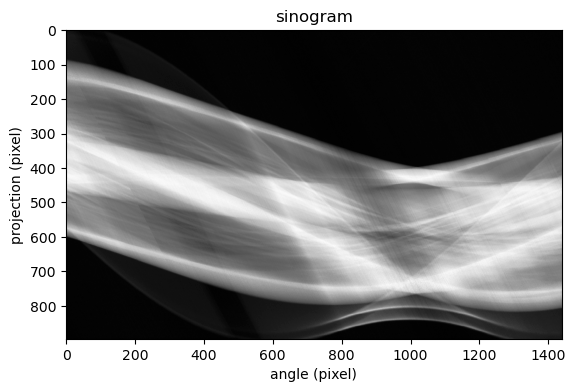

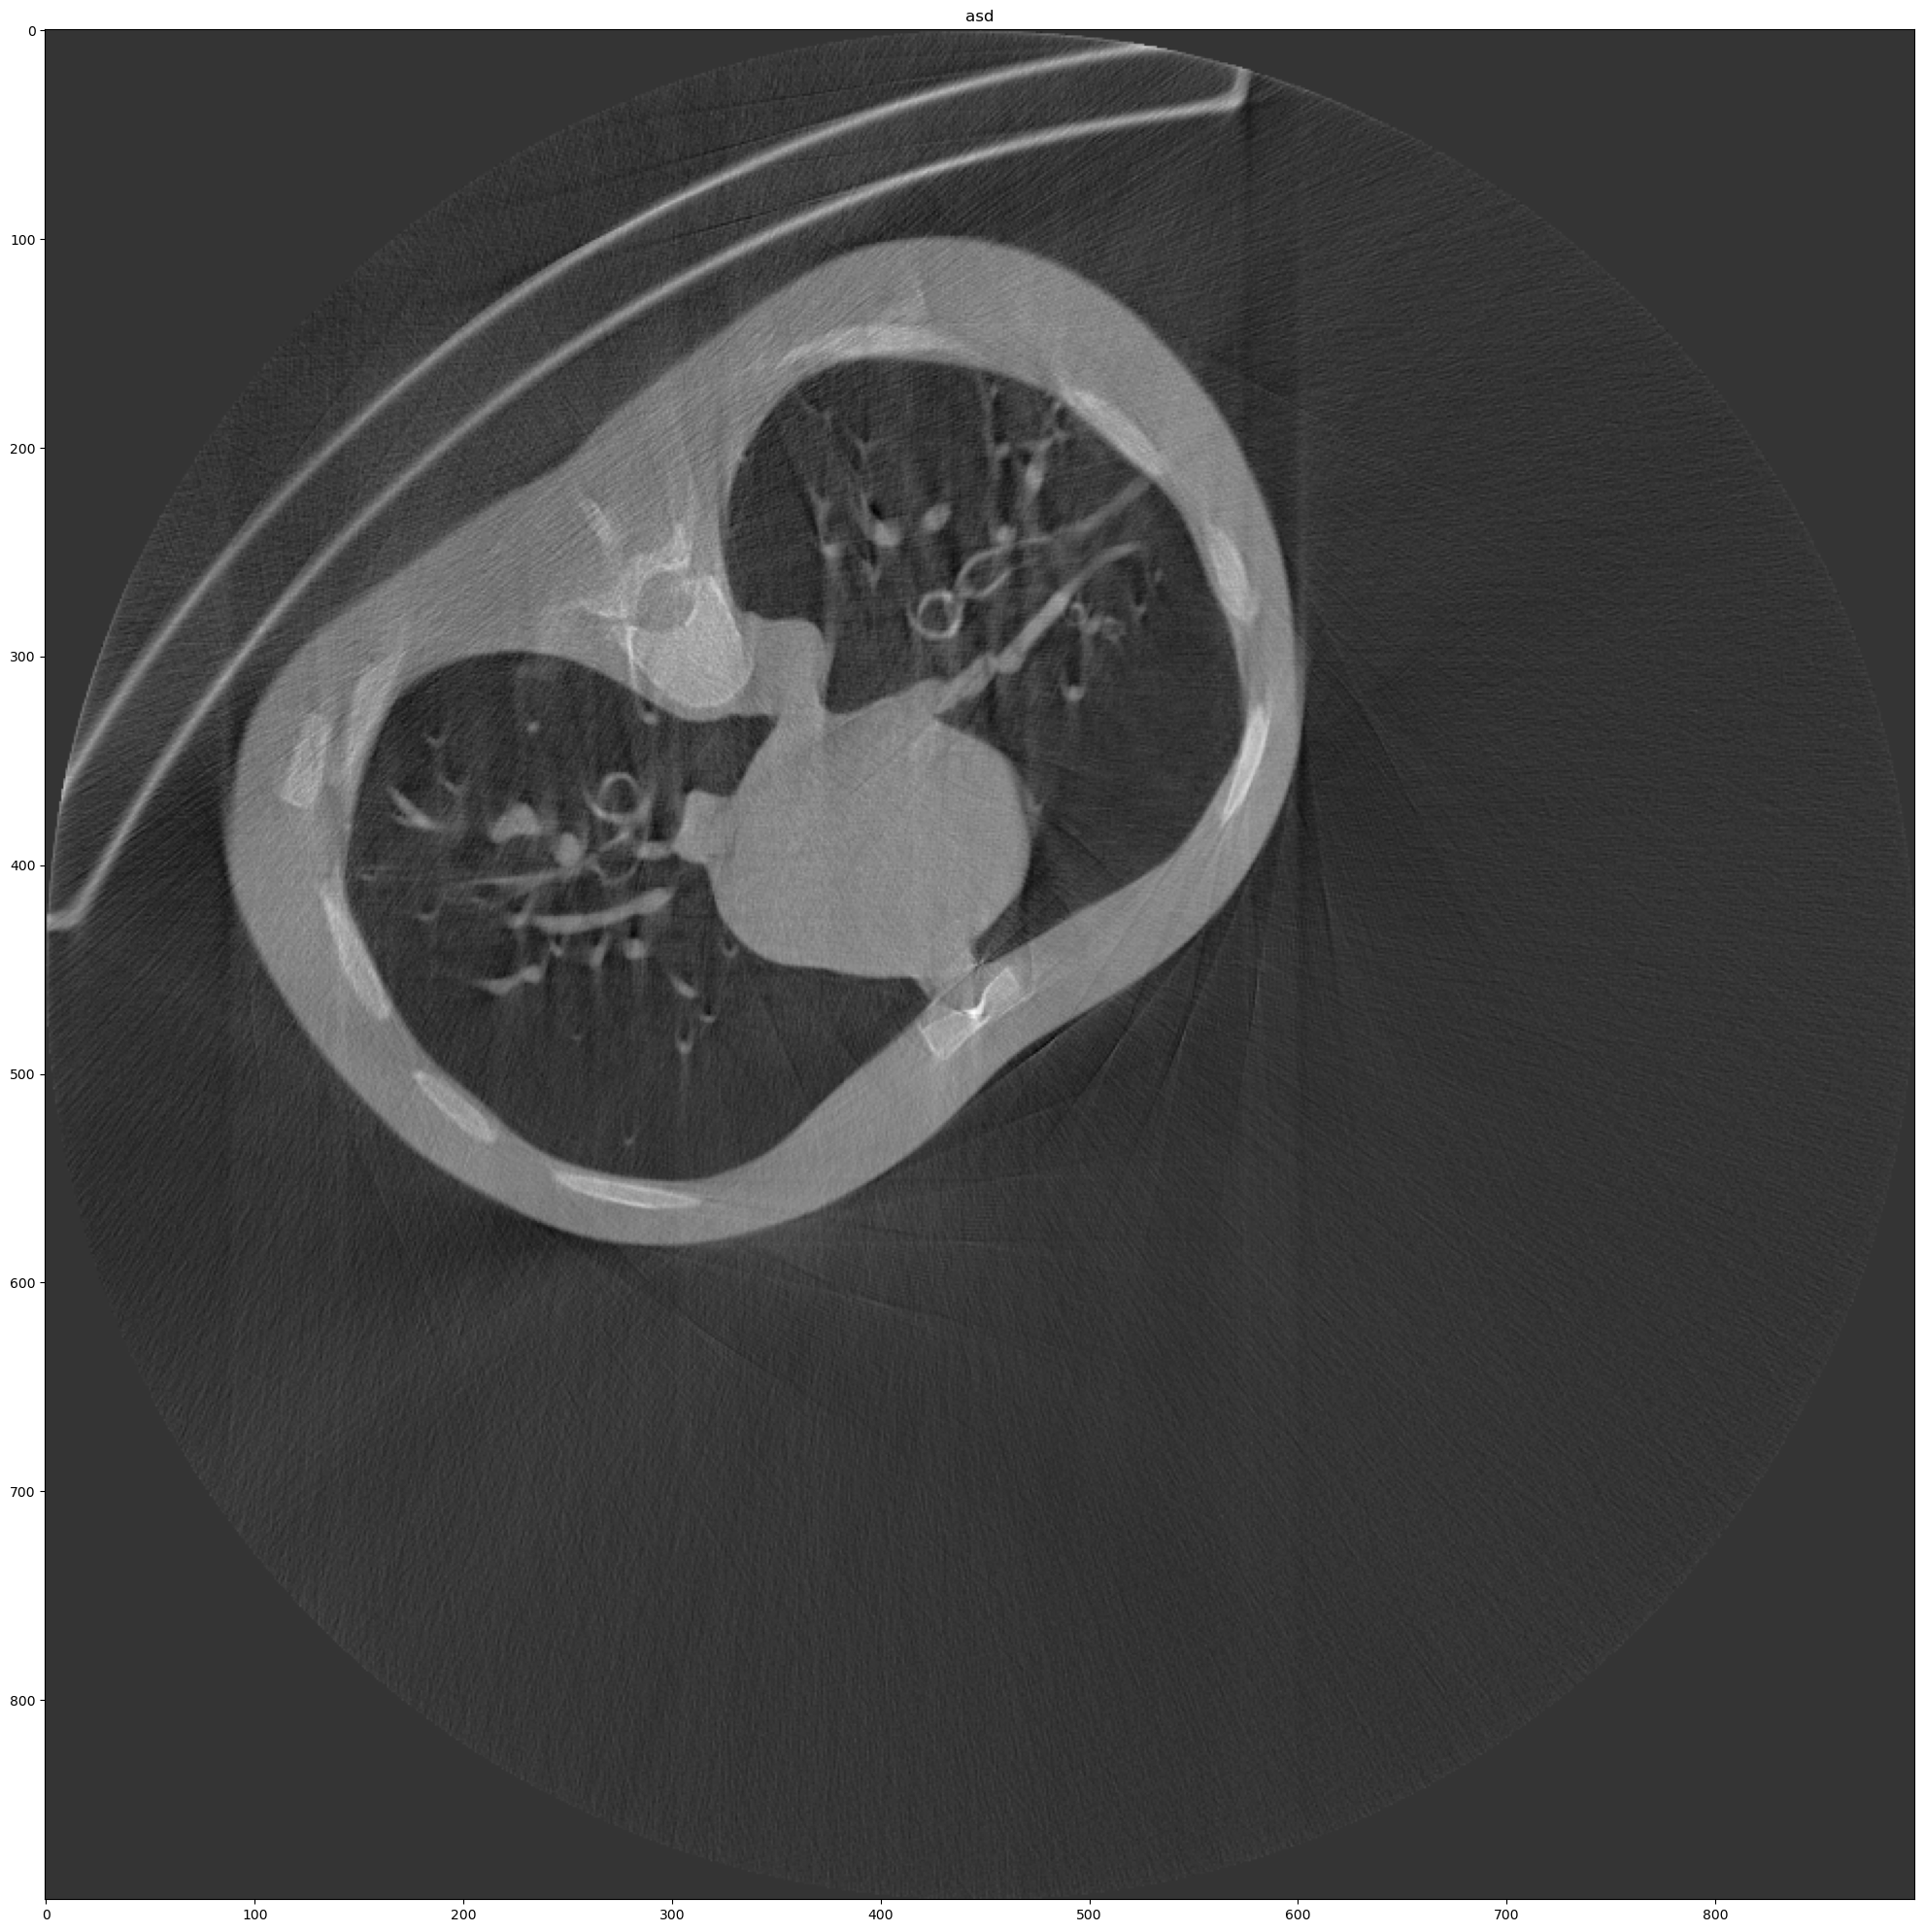

In [88]:
def do_only_1_slice(slice_idx):
    original_views=strips["020"]
    views=original_views[:(len(original_views)-(len(original_views)%ANGLES))]
    views_per_angle=len(views)//ANGLES
    views=np.stack([views[i::ANGLES].reshape((views_per_angle*THICKNESS,PROJECTIONS)) for i in range(ANGLES)])
    first_idxs=list(range(ANGLES))
    z_deltas=np.ceil(np.linspace(0, -THICKNESS, ANGLES, endpoint=False)).astype(int)
    split_views=[]
    second_idxs=list(np.full(ANGLES,slice_idx)+z_deltas)
    idxs=list(zip(first_idxs, second_idxs))
    arr=np.array([np.copy(views[idx]) for idx in idxs])
    sinoo=create_sinogram(arr)
    lung = iradon(np.array(sinoo),theta=theta,circle=True)
    plot_lung(lung,"asd")

do_only_1_slice(128)

In [90]:
def create_all_sinograms(dose, original_views, parallel_jobs=mp.cpu_count()):
    print(f"THE CREATION OF {dose} mAs SINOGRAMS HAS STARTED.")
    views=original_views[:(len(original_views)-(len(original_views)%ANGLES))]
    views_per_angle=len(views)//ANGLES
    views=np.stack([views[i::ANGLES].reshape((views_per_angle*THICKNESS,PROJECTIONS)) for i in range(ANGLES)])
    first_idxs=list(range(ANGLES))
    z_deltas=np.ceil(np.linspace(0, -THICKNESS, ANGLES, endpoint=False)).astype(int)
    split_views=[]
    for i in range(THICKNESS-1,views_per_angle*THICKNESS):
        second_idxs=list(np.full(ANGLES,i)+z_deltas)
        idxs=list(zip(first_idxs, second_idxs))
        arr=np.array([np.copy(views[idx]) for idx in idxs])
        split_views.append(arr)
    with mp.Pool(parallel_jobs) as pool:
        slices=pool.map(create_sinogram, split_views)
    print(f"THE CREATION OF {dose} mAs SINOGRAMS HAS FINISHED.")
    return slices

In [ ]:
all_sinograms=dict()
for dose, views in strips.items():
        all_sinograms[dose]=create_all_sinograms(dose, views)

THE CREATION OF 020 mAs SINOGRAMS HAS STARTED.
THE CREATION OF 020 mAs SINOGRAMS HAS FINISHED.
THE CREATION OF 080 mAs SINOGRAMS HAS STARTED.
THE CREATION OF 080 mAs SINOGRAMS HAS FINISHED.
THE CREATION OF 280 mAs SINOGRAMS HAS STARTED.


## Image restoration / interpolation

In [ ]:
def remove_horizontal_lines(sinogram): #Might be needed if using trigonometry and rounding
    gray = np.array(sinogram)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,
    horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(gray, [c], -1, 255, 2)

    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 6))

    result = 255 - cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel,
    iterations=1)

    plt.imshow(result, cmap = 'gray')#, interpolation = 'bicubic')
    return result

In [ ]:
def remove_horizontal_lines2(sinogram):
    gray = np.array(sinogram)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100,1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    #print(detected_lines)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(gray, [c], -1, 255, 2)

    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
    result = 255 - cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)

    plt.imshow(result, cmap = 'gray')
    plt.imshow(detected_lines, cmap='gray')
    return result

In [ ]:
def remove_horizontal_lines3(sinogram):
    gray = np.array(sinogram)
    edges = cv2.Canny(gray,50,150,apertureSize = 3)
    lines = cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/180, threshold=100,lines=np.array([]), minLineLength=100,maxLineGap=80)
    a,b,c = lines.shape
    for i in range(a):
        #TODO: instead should smooth/interpolate these lines, not draw them in black, but I don't know how to do it.
        cv2.line(gray, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 3, cv2.LINE_AA)
    plt.imshow(gray, cmap='gray')

In [ ]:
def apply_filters(sinogram):
    return sinogram.filter(ImageFilter.SMOOTH_MORE)
    #return sinogram.resize((45, 56), Image.BICUBIC)

## Save nice sinograms

In [ ]:
for dose, sinograms in all_sinograms.items():
    path=f"/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose{dose}/sinograms"
    for idx, sinogram in enumerate(sinograms):
        np.save(f"{path}/{idx}.npy",np.array(sinogram))
        print(f"Sinogram {idx} saved at {path}/{idx}.npy")

## Inverse Radon - Lung creation

In [ ]:
def create_lung(dose, idx, sinogram, theta = np.linspace(0, 180, 1440, endpoint=False)):
    lung = iradon(np.array(sinogram),theta=theta,circle=True)
    path=f"/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose{dose}/slices/{idx}.npy"
    np.save(path,np.array(lung))
    #plot_lung(lung, f"Slice number {idx}")
    return lung

In [ ]:
def create_all_lungs(dose, sinograms, parallel_jobs=mp.cpu_count()):
    print(f"THE CREATION OF {dose} mAs SLICES HAS STARTED.")
    with mp.Pool(parallel_jobs) as pool:
        slices=pool.starmap(functools.partial(create_lung,dose), zip(list(range(len(sinograms))),sinograms))
    print(f"THE CREATION OF {dose} mAs SLICES HAS FINISHED.")
    return slices

In [ ]:
cts=dict()
for dose, sinograms in all_sinograms.items():
    cts[dose]=create_all_lungs(dose, sinograms)

## Further experiment

### Adding shift

In [ ]:
for i in np.asarray(np.linspace(0,2880,10)).astype(int):
    sinogram = create_sinogram_stupid_360(strips,shift=i)
    theta = np.linspace(0, 360, 2880, endpoint=False)
    reconstruction_fbp = iradon(np.array(sinogram),theta=theta, output_size=512)#, circle=True)
    
    plt.figure()
    plt.title("Reconstruction\nFiltered back projection")
    plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
    plt.show()

In [ ]:
for s in np.linspace(0,MAX_DISPLACEMENT,HALF_PROJECTIONS):
    for theta in np.linspace(0,HALF_VIEW_ANGLE,HALF_ANGLES):
        alpha=theta-math.asin(s/SMALL_R)
        print(alpha)